<a href="https://colab.research.google.com/github/Prajwal011/LLM-s/blob/main/Rag_chroma_db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### Load and Clean dataset

In [2]:
from datasets import load_dataset

issues_dataset = load_dataset("lewtun/github-issues", split="train")

issues_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/3019 [00:00<?, ? examples/s]

Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 3019
})

In [3]:
issues_dataset = issues_dataset.filter(
    lambda x: (x["is_pull_request"] == False and len(x["comments"]) > 0)
)

# issues_dataset keeping necessary columns
columns = issues_dataset.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
issues_dataset = issues_dataset.remove_columns(columns_to_remove)
issues_dataset

Filter:   0%|          | 0/3019 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 808
})

In [4]:
issues_dataset.set_format("pandas")
df = issues_dataset[:]
df["comments"][1].tolist()

["Hi ! I guess the caching mechanism should have considered the new `filter` to be different from the old one, and don't use cached results from the old `filter`.\r\nTo avoid other users from having this issue we could make the caching differentiate the two, what do you think ?",
 "If it's easy enough to implement, then yes please 😄  But this issue can be low-priority, since I've only encountered it in a couple of `transformers` CI tests.",
 "Well it can cause issue with anyone that updates `datasets` and re-run some code that uses filter, so I'm creating a PR",
 "I just merged a fix, let me know if you're still having this kind of issues :)\r\n\r\nWe'll do a release soon to make this fix available",
 'Definitely works on several manual cases with our dummy datasets, thank you @lhoestq !',
 'Fixed by #2947.']

In [5]:
comments_df = df.explode("comments", ignore_index=True)
comments_df.head(4)

,html_url,title,comments,body
0,https://github.com/huggingface/datasets/issues...,Protect master branch,"Cool, I think we can do both :)",After accidental merge commit (91c55355b634d0d...
1,https://github.com/huggingface/datasets/issues...,Protect master branch,@lhoestq now the 2 are implemented.\r\n\r\nPle...,After accidental merge commit (91c55355b634d0d...
2,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Hi ! I guess the caching mechanism should have...,## Describe the bug\r\nAfter upgrading to data...
3,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,"If it's easy enough to implement, then yes ple...",## Describe the bug\r\nAfter upgrading to data...


In [6]:
from datasets import Dataset

comments_dataset = Dataset.from_pandas(comments_df)

comments_dataset = comments_dataset.map(
    lambda x: {"comment_length": len(x["comments"].split())}
)

Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

In [7]:
comments_dataset = comments_dataset.filter(lambda x: x["comment_length"] > 15)
comments_dataset

Filter:   0%|          | 0/2964 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length'],
    num_rows: 2175
})

In [8]:
def concatenate_text(examples):
    return {
        "text": examples["title"]
        + " \n "
        + examples["body"]
        + " \n "
        + examples["comments"]
    }


comments_dataset = comments_dataset.map(concatenate_text)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

Embedding dataset using sentence transformers


In [9]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [10]:
import torch

device = torch.device("cuda")
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [11]:
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

In [12]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [13]:
embedding = get_embeddings(comments_dataset["text"][0])
embedding.shape

torch.Size([1, 768])

In [14]:
embeddings_dataset = comments_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

##What is Chroma DB?

Chroma DB is an open-source vector store used for storing and retrieving vector embeddings. Its main use is to save embeddings along with metadata to be used later by large language models. Additionally, it can also be used for semantic search engines over text data.

Chroma DB key features:

Supports different underlying storage options like DuckDB for standalone or ClickHouse for scalability.
Provides SDKs for Python and JavaScript/TypeScript.
Focuses on simplicity, speed, and enabling analysis.
Chroma DB offers a self-hosted server option. If you need a managed vector database platform, check out the Pinecone Guide for Mastering Vector Databases.

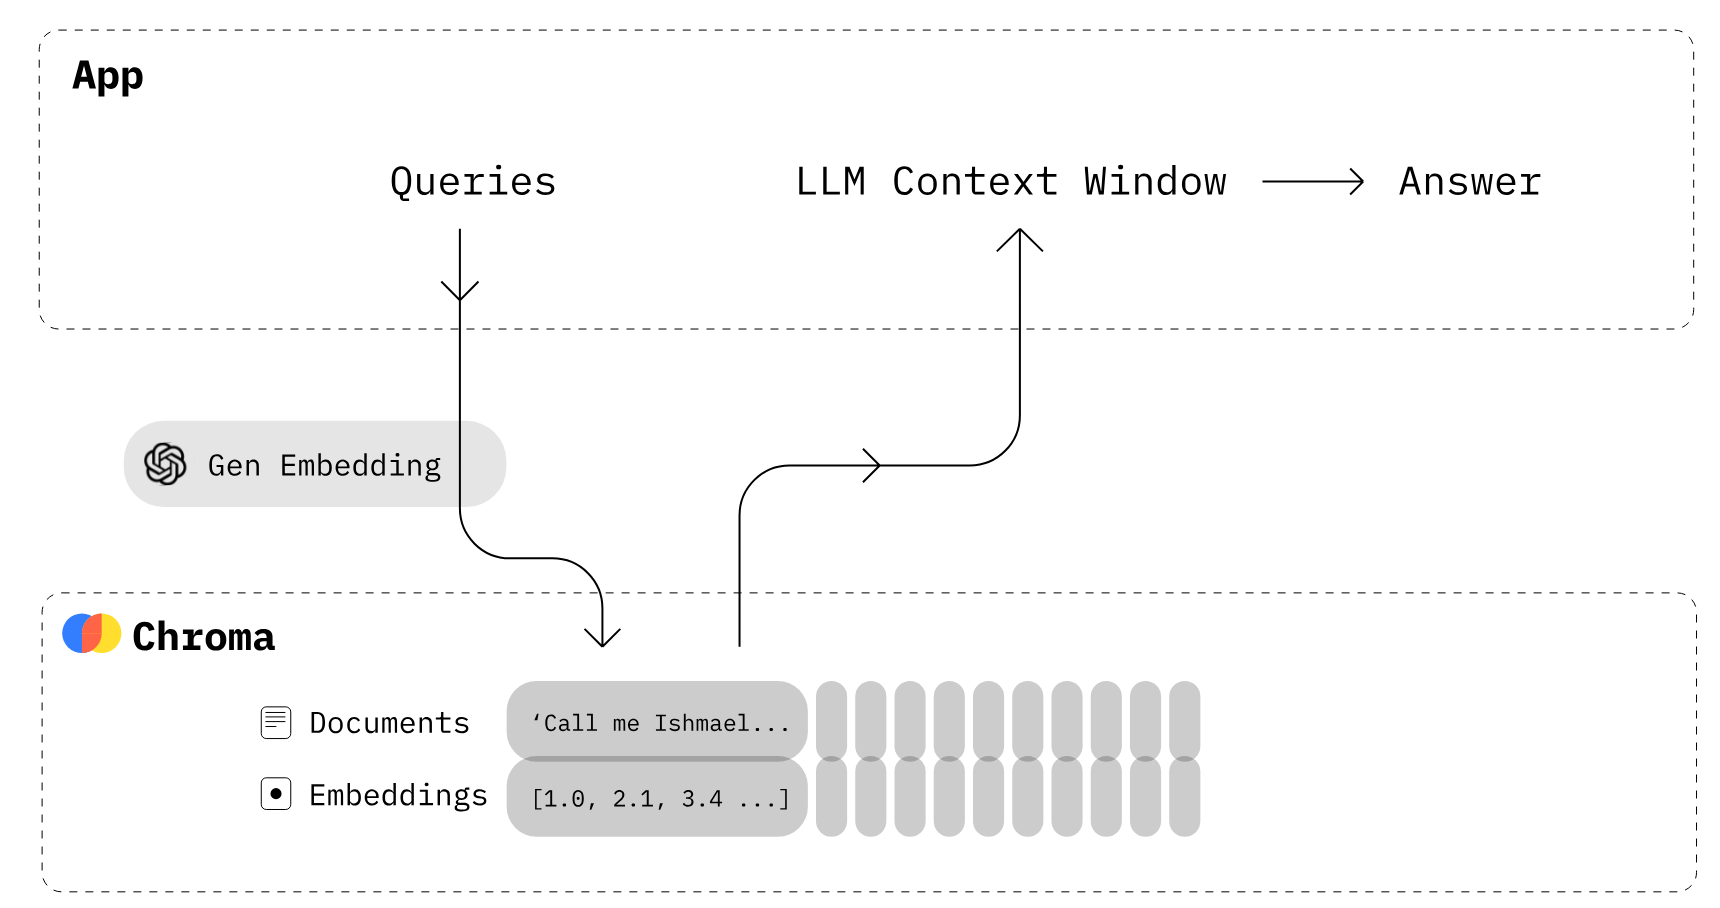


https://www.datacamp.com/tutorial/chromadb-tutorial-step-by-step-guide

In [15]:
import chromadb

# setup Chroma in-memory, for easy prototyping. Can add persistence easily!
client = chromadb.Client()

# Create collection. get_collection, get_or_create_collection, delete_collection also available!
collection = client.create_collection("all-my-documents")

In [16]:
# Add docs to the collection. Can also update and delete. Row-based API coming soon!
collection.add(
    ids = [str(i) for i in range(len(comments_dataset['text'])) ] ,
    documents = comments_dataset['text']
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:28<00:00, 2.94MiB/s]


In [18]:
question = 'how to load dataset'
#Retrieves n_resuts(n) queries from collection similar to question provided
collection.query(query_texts=[question],n_results = 4)

{'ids': [['1041', '1042', '1043', '210']],
 'distances': [[0.7150458097457886,
   0.7223697304725647,
   0.7339720726013184,
   0.7995660305023193]],
 'metadatas': [[None, None, None, None]],
 'embeddings': None,
 'documents': [["load the local dataset \n your guidebook's example is like\r\n>>>from datasets import load_dataset\r\n>>> dataset = load_dataset('json', data_files='my_file.json')\r\nbut the first arg is path...\r\nso how should i do if i want to load the local dataset for model training?\r\ni will be grateful if you can help me handle this problem!\r\nthanks a lot! \n You should rephrase your question or give more examples and details on what you want to do.\r\n\r\nit’s not possible to understand it and help you with only this information.",
   "load the local dataset \n your guidebook's example is like\r\n>>>from datasets import load_dataset\r\n>>> dataset = load_dataset('json', data_files='my_file.json')\r\nbut the first arg is path...\r\nso how should i do if i want to lo

To improve performance we can pass embeddings as well


In [19]:
collection2 = client.create_collection("docs_with_embedding")

collection2.add(
    ids = [str(i) for i in range(len(comments_dataset['text'])) ] ,
    documents = comments_dataset['text'],
    embeddings= embeddings_dataset['embeddings']
)

In [25]:
def query_db(question, collection, top_k=3):
   q_embeddings = get_embeddings([question])
   results = collection.query(query_embeddings=q_embeddings.numpy().tolist(), n_results=top_k)
   return ' '.join(results['documents'][0])

question = "How to load dataset?"
context = query_db(question, collection)
context

["load the local dataset \n your guidebook's example is like\r\n>>>from datasets import load_dataset\r\n>>> dataset = load_dataset('json', data_files='my_file.json')\r\nbut the first arg is path...\r\nso how should i do if i want to load the local dataset for model training?\r\ni will be grateful if you can help me handle this problem!\r\nthanks a lot! \n You should rephrase your question or give more examples and details on what you want to do.\r\n\r\nit’s not possible to understand it and help you with only this information.",
 'nlp.load_dataset() gives "TypeError: list_() takes exactly one argument (2 given)" \n I\'m trying to load datasets from nlp but there seems to have error saying \r\n"TypeError: list_() takes exactly one argument (2 given)"\r\n\r\ngist can be found here\r\nhttps://gist.github.com/saahiluppal/c4b878f330b10b9ab9762bc0776c0a6a \n If you want to load a local dataset, make sure you include a `./` before the folder name. ',
 "load the local dataset \n your guidebook

In [27]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-base-squad2"

nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

question = 'how to load dataset'

def query_db(question, collection, top_k=3):
   q_embeddings = get_embeddings([question])
   results = collection.query(query_embeddings=q_embeddings.numpy().tolist(), n_results=top_k)
   return ' '.join(results['documents'][0])


context = query_db(question, collection)

QA_input = {
    'question': question,
    'context': context
}
res = nlp(QA_input)

In [28]:
res

{'score': 0.06476997584104538,
 'start': 867,
 'end': 918,
 'answer': 'make sure you include a `./` before the folder name'}